# Microbiome Analysis in R

In this tutorial, we introduce basic microbiome analysis starting from the 
processed output from 16S rRNA sequencing, i.e. feature table. Specifically, 
we will look at the microbial compositions from different body sites of human, 
including gut, tongue, left palm, and right palm. 

This tutorial is adapted from https://www.yanh.org/2021/01/01/microbiome-r/. 
Input data is sourced from Caporaso et. al, 2011 (https://pubmed.ncbi.nlm.nih.gov/21624126/)
and processed using QIIME2.Data used in this tutorial were sequenced on an 
Illumina HiSeq using the Earth Microbiome Project hypervariable region 4(V4) 
16S rRNA sequencing protocol. 


# 1. Load Packages

Uncomment and run this chunk of code to install all required packages at once.
You can select a block of code and press 'ctrl + shift + C` to uncomment the 
code chunk. 

In [ ]:
# p1 <- c("tidyverse", "vegan", "BiocManager")
# p2 <- c("phyloseq", "DESeq2", "ComplexHeatmap")
# load_package <- function(p) {
# if (!requireNamespace(p, quietly = TRUE)) {
# ifelse(p %in% p1,
# install.packages(p, repos = "http://cran.us.r-project.aorg/"),
# BiocManager::install(p))
# }
# library(p, character.only = TRUE, quietly = TRUE)
# }
# invisible(lapply(c(p1,p2), load_package))

If you prefer to install packages one at a time (for trouble shooting.etc), you 
can do it here. 

In [ ]:
# install.packages('tidyverse', repos = "http://cran.us.r-project.aorg/")
# install.packages('vegan', repos = "http://cran.us.r-project.aorg/")
# install.packages('BiocManager', repos = "http://cran.us.r-project.aorg/")
# library(BicMaanger)
# BiocManager::install("phyloseq")
# BiocManager::install("DESeq2")
# BiocManager::install("ComplexHeatmap")

Now load all necessary packages:

In [1]:
library(tidyverse)      
library(vegan)          
library(BiocManager)
library(DESeq2)
library(ComplexHeatmap)
library(phyloseq)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combi

# 2. Load Data

After sequencing, you will get some (fastq/fast5/h5) files from the sequencing. 
These files contain the nucleotide information. If the sequenced sample is a mixed 
community, i.e. metagenomics, you need to identify where the reads come from 
(specific taxa and samples). 

Established microbial pipelines such as QIIME2 can convert these nucleotide 
information to the following outputs: 

* Feature table (Necessary), a matrix containing the abundances of detected 
microbial features (OTUs, ASVs, microbial markers)
* Taxonomy table (Optional), an array indicating the taxonomic assignment of 
features, which can be integrated in biom format.
* Phylogenetic tree (Optional), a phylogenetic tree indicating the evolutional 
similarity of microbial features, potentially used when calculating phylogenetic 
diversity metrics (optionally integrated in biom format).
* Metadata, a matrix containing the infomation for analysis (optionally 
integrated in biom format).


In [2]:
# load otu table (feature table)
otu <- read.table(file = 'feature-table.tsv', sep = '\t', header = T, row.names = 1, skip = 1, comment.char = "") # 770 otus, 34 samples

# load taxonomy (feature metadata)
taxonomy <- read.table(file = 'taxonomy.tsv', sep = '\t', header = T, row.names = 1)

# load metadata
metadata <- read.table(file = "sample-metadata.tsv", sep = "\t", header = T, row.names = 1)

# phylogenetic tree will be imported later

# 3. Clean Data

Let's do some data cleaning for our taxonomy table.

In [3]:
# clean the taxonomy
tax <- taxonomy %>% 
  select(Taxon) %>% 
  separate(Taxon, c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"), "; ")

# fill up NA values
tax.clean <- data.frame(row.names = row.names(tax), 
                        Kingdom = str_replace(tax[, 1], "k__", ""), 
                        Phylum = str_replace(tax[, 2], "p__", ""), 
                        Class = str_replace(tax[, 3], "c__", ""), 
                        Order = str_replace(tax[, 4], "o__", ""), 
                        Family = str_replace(tax[, 5], "f__", ""), 
                        Genus = str_replace(tax[, 6], "g__", ""), 
                        Species = str_replace(tax[, 7], "s__", ""),
                        stringsAsFactors = FALSE
                        )

tax.clean[is.na(tax.clean)] <- ""
tax.clean[tax.clean  == "__"] <- ""

for (i in 1:nrow(tax.clean)){
  if (tax.clean[i,7] != ""){
    tax.clean$Species[i] <- paste(tax.clean$Genus[i], tax.clean$Species[i], sep = " ")
  } else if (tax.clean[i,2] == ""){
    kingdom <- paste("Unclassified", tax.clean[i,1], sep = " ")
    tax.clean[i, 2:7] <- kingdom
  } else if (tax.clean[i,3] == ""){
    phylum <- paste("Unclassified", tax.clean[i,2], sep = " ")
    tax.clean[i, 3:7] <- phylum
  } else if (tax.clean[i,4] == ""){
    class <- paste("Unclassified", tax.clean[i,3], sep = " ")
    tax.clean[i, 4:7] <- class
  } else if (tax.clean[i,5] == ""){
    order <- paste("Unclassified", tax.clean[i,4], sep = " ")
    tax.clean[i, 5:7] <- order
  } else if (tax.clean[i,6] == ""){
    family <- paste("Unclassified", tax.clean[i,5], sep = " ")
    tax.clean[i, 6:7] <- family
  } else if (tax.clean[i,7] == ""){
    tax.clean$Species[i] <- paste("Unclassified ",tax.clean$Genus[i], sep = " ")
  }
}

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 201 rows [2, 3, 5, 8, 18, 19, 24, 37, 41, 42, 44, 45, 49, 61, 64,
66, 82, 84, 86, 90, ...].”


# 4. Build a phyloseq object

Many microbiome analysis (alpha diversity, beta diversity) are standardized by 
the package phyloseq. In order to run these analyses using phyloseq. Let's build 
a phyloseq object first. 

In [4]:
OTU = otu_table(as.matrix(otu), taxa_are_rows = TRUE)
TAX = tax_table(as.matrix(tax.clean))
SAMPLE <- sample_data(metadata)
TREE = read_tree("tree.nwk")

# merge all data to build a phyloseq object
ps <- phyloseq(OTU, TAX, SAMPLE,TREE)

# 5. Rarefy samples 

Let's take a look at the rarefaction curve first. The curve is created by 
randomly re-sampling the pool of N samples several times and then plotting the 
average number of species found in each sample. Generally, it initially grows 
rapidly (as more common species are found) and then slightly flattens (as the 
rarest species remain to be sampled).


In [6]:
# check rarefaction curves
knitr::include_graphics('rarefaction-1.png')

[1] "rarefaction-1.png"
attr(,"class")
[1] "knit_image_paths" "knit_asis"       

As we can see, a sequencing depth of 1000 has captured most taxa. To 
minimize the bias from varying sequencing depth. Rarefaction is recommended 
before calculating the diversity metrics. To be consistent with the original 
publication, all samples are rarefied (re-sampled) to the sequencing depth of 
1103. Note that since it's a random sampling process, the result is unlikely to 
be identical as the publication.

In [7]:
set.seed(111) # keep result reproductive
ps.rarefied = rarefy_even_depth(ps, rngseed=1, sample.size=1103, replace=F)

`set.seed(1)` was used to initialize repeatable random subsampling.

Please record this for your records so others can reproduce.

Try `set.seed(1); .Random.seed` for the full vector

...

3 samples removedbecause they contained fewer reads than `sample.size`.

Up to first five removed samples are: 


L3S242L3S341L3S360

...

104OTUs were removed because they are no longer 
present in any sample after random subsampling


...



# 6. Alpha diversity

Alpha diversity metrics assess the species diversity with the ecosystems, 
telling us how diverse a sequenced community is.

Some common alpha diversity metrics:
- observed: number of unique species identified in each sample
- Shannon: shannon diversity index, which combines species richness and evenness


## 6.1 Plot Observed and Shannon index across communities

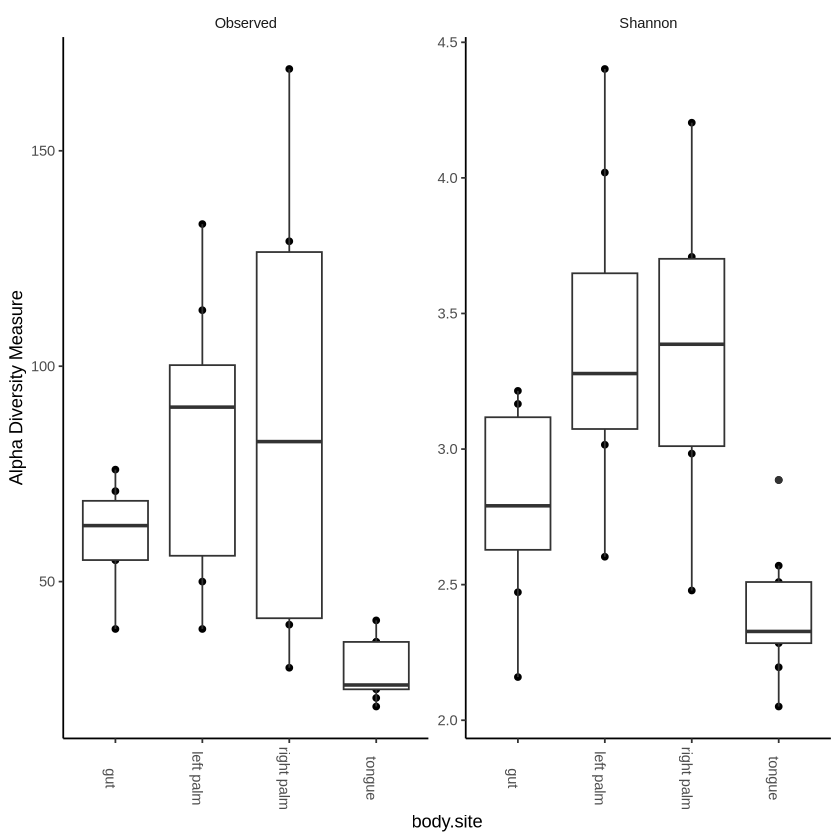

In [8]:
plot_richness(ps.rarefied, x="body.site", measure=c("Observed", "Shannon")) + 
  geom_boxplot() +
  theme_classic() +
  theme(strip.background = element_blank(), axis.text.x.bottom = element_text(angle = -90))

## 6.2 Wilcox tests

We could see tongue samples had the lowest alpha diversity. Next, some 
statistics: pairwise test with Wilcoxon rank-sum test, corrected by FDR method.

In [9]:
rich = estimate_richness(ps.rarefied, measures = c("Observed", "Shannon"))
wilcox.observed <- pairwise.wilcox.test(rich$Observed, 
                                        sample_data(ps.rarefied)$body.site, 
                                        p.adjust.method = "BH")
tab.observed <- wilcox.observed$p.value %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = "group1") %>%
  gather(key="group2", value="p.adj", -group1) %>%
  na.omit()
tab.observed

Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(xi, xj, paired = paired, ...):
“cannot compute exact p-value with ties”


,group1,group2,p.adj
,<chr>,<chr>,<dbl>
1,left palm,gut,0.309861520
2,right palm,gut,1.000000000
3,tongue,gut,0.002644163
5,right palm,left palm,1.000000000
6,tongue,left palm,0.002644163
9,tongue,right palm,0.015796057


The species richness of tongue is significantly different from all the other 
body sites (gut, left palm, and right palm).

In [10]:
wilcox.shannon <- pairwise.wilcox.test(rich$Shannon, 
                                       sample_data(ps.rarefied)$body.site, 
                                       p.adjust.method = "BH")
tab.shannon <- wilcox.shannon$p.value %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = "group1") %>%
  gather(key="group2", value="p.adj", -group1) %>%
  na.omit()
tab.shannon

,group1,group2,p.adj
,<chr>,<chr>,<dbl>
1,left palm,gut,0.074825175
2,right palm,gut,0.170229770
3,tongue,gut,0.071904566
5,right palm,left palm,0.851814852
6,tongue,left palm,0.000987248
9,tongue,right palm,0.008391608


When looking at Shannon diversity index, which takes into account of not only
species richness but also species evenness, tongue is significantly different 
from left palm and right palm. 


# 7. Beta Diversity

## 7.1 Ordination plots

Beta diversity metrics assess the dissimilarity between ecosystem, telling you 
to what extend one community is different from another. Here are some demo code 
using Bray Curtis and binary Jaccard distance metrics.

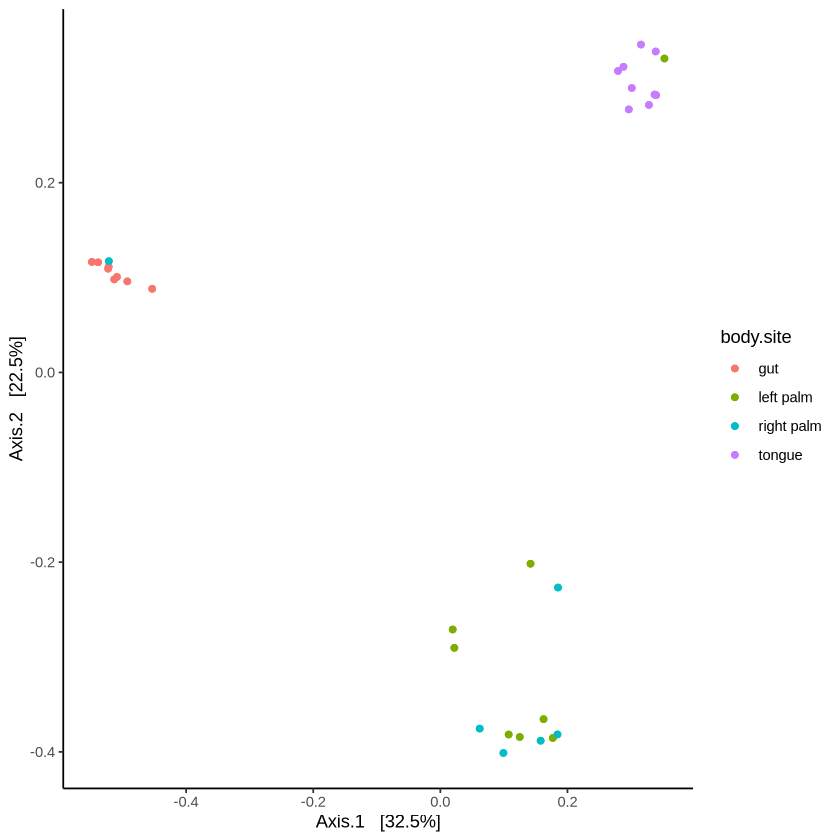

In [11]:
dist = phyloseq::distance(ps.rarefied, method="bray")
ordination = ordinate(ps.rarefied, method="PCoA", distance=dist)
plot_ordination(ps.rarefied, ordination, color="body.site") + 
  geom_point(size = 1.5) +
  theme_classic() +
  theme(strip.background = element_blank())

We can see that mostly samples cluster by body sites. Samples from the gut and 
tongue area are separated from samples from the left and right palm area.

## 7.2 Permanova

In [17]:
metadata <- data.frame(sample_data(ps.rarefied))
test.adonis <- adonis(unname(dist) ~ body.site, data = metadata)
test.adonis <- as.data.frame(test.adonis$aov.tab)
test.adonis

'adonis' will be deprecated: use 'adonis2' instead



,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
body.site,3,5.213908,1.7379693,7.975992,0.4698395,0.001
Residuals,27,5.883302,0.2179001,NA,0.5301605,NA
Total,30,11.097210,NA,NA,1.0000000,NA


If you encounter an error using adonis, you can use adonis2, which gives similar 
results. The use of function slightly varies from adonis. 

In [ ]:
# metadata <- data.frame(sample_data(ps.rarefied))
# test.adonis <- adonis2(dist ~ body.site, data = metadata)
# test.adonis <- as.data.frame(test.adonis)
# test.adonis

## 7.2 Pairwise PERMANOVA

In [18]:
cbn <- combn(x=unique(metadata$body.site), m = 2)
p <- c()

for(i in 1:ncol(cbn)){
ps.subs <- subset_samples(ps.rarefied, body.site %in% cbn[,i])
metadata_sub <- data.frame(sample_data(ps.subs))
permanova_pairwise <- adonis(unname(phyloseq::distance(ps.subs, method = "bray")) ~ body.site, 
                             data = metadata_sub)
p <- c(p, permanova_pairwise$aov.tab$`Pr(>F)`[1])
}

p.adj <- p.adjust(p, method = "BH")
p.table <- cbind.data.frame(t(cbn), p=p, p.adj=p.adj)
p.table

'adonis' will be deprecated: use 'adonis2' instead

'adonis' will be deprecated: use 'adonis2' instead

'adonis' will be deprecated: use 'adonis2' instead

'adonis' will be deprecated: use 'adonis2' instead

'adonis' will be deprecated: use 'adonis2' instead

'adonis' will be deprecated: use 'adonis2' instead



1,2,p,p.adj
<chr>,<chr>,<dbl>,<dbl>
gut,left palm,0.001,0.0030
gut,right palm,0.003,0.0036
gut,tongue,0.001,0.0030
left palm,right palm,0.931,0.9310
left palm,tongue,0.002,0.0030
right palm,tongue,0.002,0.0030


As we could see, there’s no difference in composition between the left and right 
palm samples. Can you run the same analysis with a binary Jaccard metrics and 
a different ordination technique NMDS, to see if the results are robust across 
different difference metrics?


Call:
anosim(x = dist, grouping = metadata$body.site) 
Dissimilarity: bray 

ANOSIM statistic R: 0.7593 
      Significance: 0.001 

Permutation: free
Number of permutations: 999


1,2,p,p.adj
<chr>,<chr>,<dbl>,<dbl>
gut,left palm,0.001,0.0015
gut,right palm,0.001,0.0015
gut,tongue,0.001,0.0015
left palm,right palm,0.768,0.7680
left palm,tongue,0.001,0.0015
right palm,tongue,0.002,0.0024


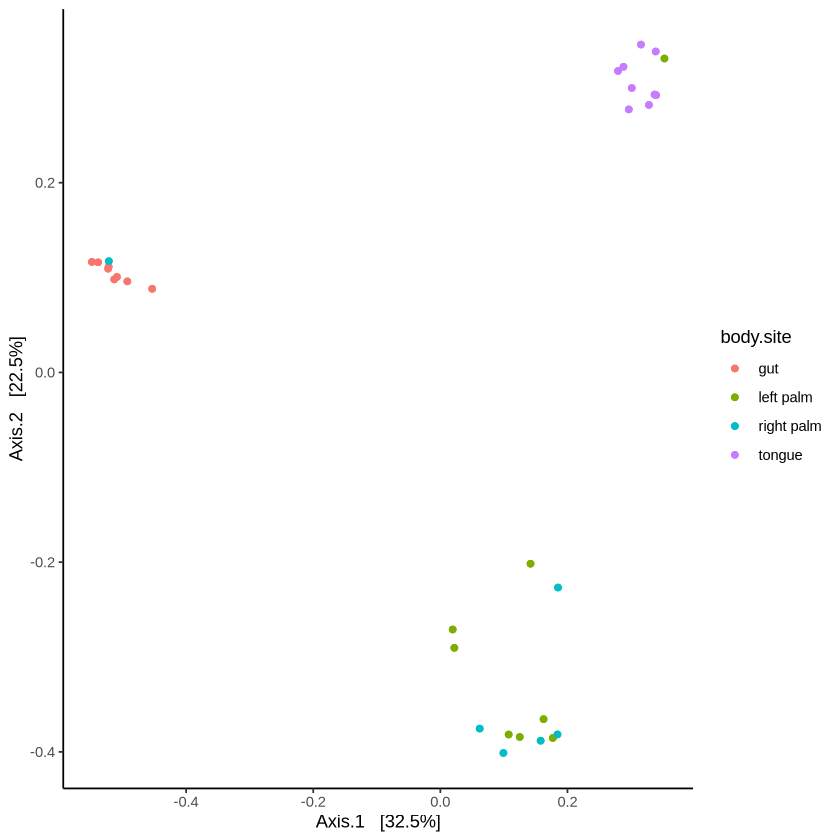

In [21]:
dist = phyloseq::distance(ps.rarefied, method = "???") # TRY JACCARD DISTANCES (BINARY)
# dist = phyloseq::distance(ps.rarefied, method = "jaccard", binary = TRUE)
ordination = ordinate(ps.rarefied, method="PCoA", distance=dist)
plot_ordination(ps.rarefied, ordination, color="body.site") + 
  geom_point(size = 1.5) +
  theme_classic() +
  theme(strip.background = element_blank())

# ANOSIM
metadata <- data.frame(sample_data(ps.rarefied))
anosim(dist, metadata$body.site)

# Pairwise ANOSIM
cbn <- combn(x=unique(metadata$body.site), m = 2)
p <- c()

for(i in 1:ncol(cbn)){
ps.subs <- subset_samples(ps.rarefied, body.site %in% cbn[,i])
metadata_sub <- data.frame(sample_data(ps.subs))
permanova_pairwise <- anosim(phyloseq::distance(ps.subs, method="jaccard", binary = TRUE), 
                             metadata_sub$body.site)
p <- c(p, permanova_pairwise$signif[1])
}

p.adj <- p.adjust(p, method = "BH")
p.table <- cbind.data.frame(t(cbn), p=p, p.adj=p.adj)
p.table

# 8. Abundance plot

Phylum level

`summarise()` has grouped output by 'Sample', 'body.site'. You can override using the `.groups` argument.


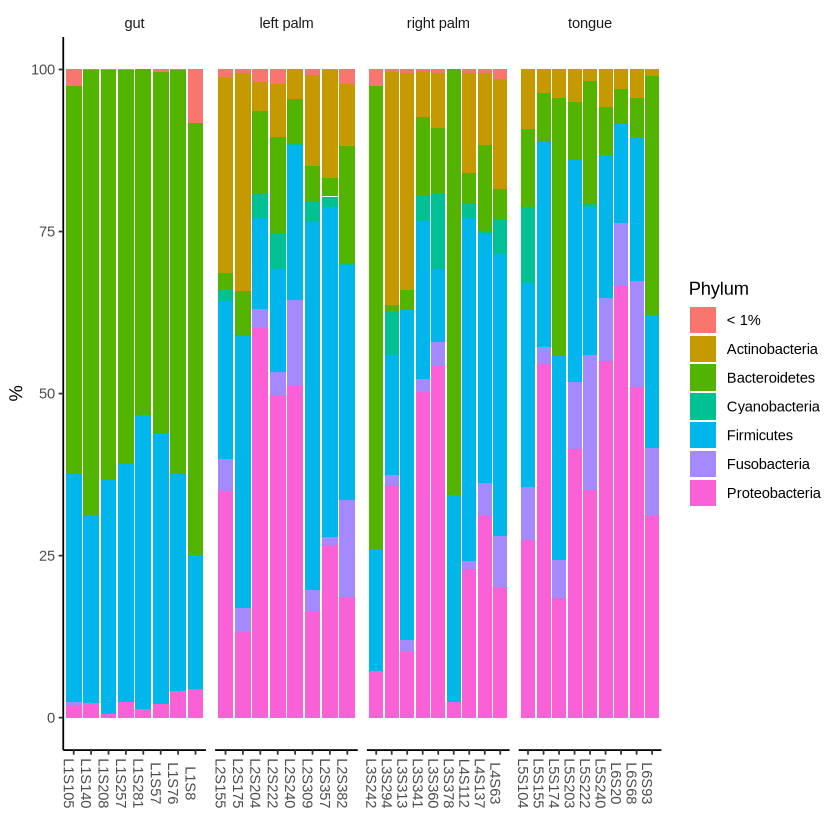

In [22]:
ps.rel = transform_sample_counts(ps, function(x) x/sum(x)*100)
# agglomerate taxa
glom <- tax_glom(ps.rel, taxrank = 'Phylum', NArm = FALSE)
ps.melt <- psmelt(glom)
# change to character for easy-adjusted level
ps.melt$Phylum <- as.character(ps.melt$Phylum)

ps.melt <- ps.melt %>%
  group_by(body.site, Phylum) %>%
  mutate(median=median(Abundance))
# select group median > 1
keep <- unique(ps.melt$Phylum[ps.melt$median > 1])
ps.melt$Phylum[!(ps.melt$Phylum %in% keep)] <- "< 1%"
#to get the same rows together
ps.melt_sum <- ps.melt %>%
  group_by(Sample,body.site,Phylum) %>%
  summarise(Abundance=sum(Abundance))

ggplot(ps.melt_sum, aes(x = Sample, y = Abundance, fill = Phylum)) + 
  geom_bar(stat = "identity", aes(fill=Phylum)) + 
  labs(x="", y="%") +
  facet_wrap(~body.site, scales= "free_x", nrow=1) +
  theme_classic() + 
  theme(strip.background = element_blank(), 
        axis.text.x.bottom = element_text(angle = -90))

Genus-level

`summarise()` has grouped output by 'Sample', 'body.site'. You can override using the `.groups` argument.


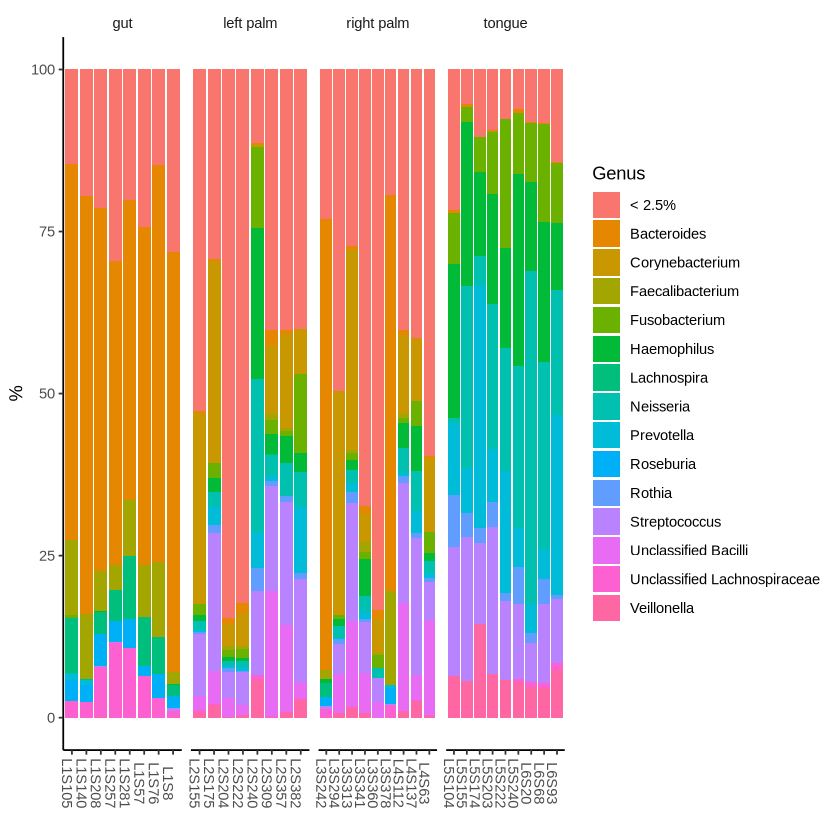

In [23]:
ps.rel = transform_sample_counts(ps, function(x) x/sum(x)*100)
# agglomerate taxa
glom <- tax_glom(ps.rel, taxrank = 'Genus', NArm = FALSE)
ps.melt <- psmelt(glom)
# change to character for easy-adjusted level
ps.melt$Genus <- as.character(ps.melt$Genus)

ps.melt <- ps.melt %>%
  group_by(body.site, Genus) %>%
  mutate(median=median(Abundance))
# select group mean > 1
keep <- unique(ps.melt$Genus[ps.melt$median > 2.5])
ps.melt$Genus[!(ps.melt$Genus %in% keep)] <- "< 2.5%"
#to get the same rows together
ps.melt_sum <- ps.melt %>%
  group_by(Sample,body.site,Genus) %>%
  summarise(Abundance=sum(Abundance))

ggplot(ps.melt_sum, aes(x = Sample, y = Abundance, fill = Genus)) + 
  geom_bar(stat = "identity", aes(fill=Genus)) + 
  labs(x="", y="%") +
  facet_wrap(~body.site, scales= "free_x", nrow=1) +
  theme_classic() + 
  theme(legend.position = "right", 
        strip.background = element_blank(), 
        axis.text.x.bottom = element_text(angle = -90))

# 9. Differential abundancce analysis

Differential abundance analysis allows you to identify differentially abundant 
taxa between groups. There’s many methods, here DESeq2 is given as anexample. 
Features are collapsed at the species-level prior to the calculation.

In [24]:
sample_data(ps)$body.site <- as.factor(sample_data(ps)$body.site) # factorize for DESeq2
ps.taxa <- tax_glom(ps, taxrank = 'Species', NArm = FALSE)

# 9.1 DESeq2

DESeq2 is a software designed for RNA-seq, but also used in microbiome analysis.
You may be troubled by the “zero” issues in microbiome analysis. A pseudo count 
is added to avoid the errors in logarithm transformation.

In [25]:
# pairwise comparison between gut and tongue
ps.taxa.sub <- subset_samples(ps.taxa, body.site %in% c("gut", "tongue"))
# filter sparse features, with > 90% zeros
ps.taxa.pse.sub <- prune_taxa(rowSums(otu_table(ps.taxa.sub) == 0) < ncol(otu_table(ps.taxa.sub)) * 0.9, ps.taxa.sub)
ps_ds = phyloseq_to_deseq2(ps.taxa.pse.sub, ~ body.site)
# use alternative estimator on a condition of "every gene contains a sample with a zero"
ds <- estimateSizeFactors(ps_ds, type="poscounts")
ds = DESeq(ds, test="Wald", fitType="parametric")
alpha = 0.05 
res = results(ds, alpha=alpha)
res = res[order(res$padj, na.last=NA), ]
taxa_sig = rownames(res[1:20, ]) # select bottom 20 with lowest p.adj values
ps.taxa.rel <- transform_sample_counts(ps, function(x) x/sum(x)*100)
ps.taxa.rel.sig <- prune_taxa(taxa_sig, ps.taxa.rel)
# Only keep gut and tongue samples
ps.taxa.rel.sig <- prune_samples(colnames(otu_table(ps.taxa.pse.sub)), ps.taxa.rel.sig)

converting counts to integer mode

using pre-existing size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 6 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



# 9.2 Heatmap

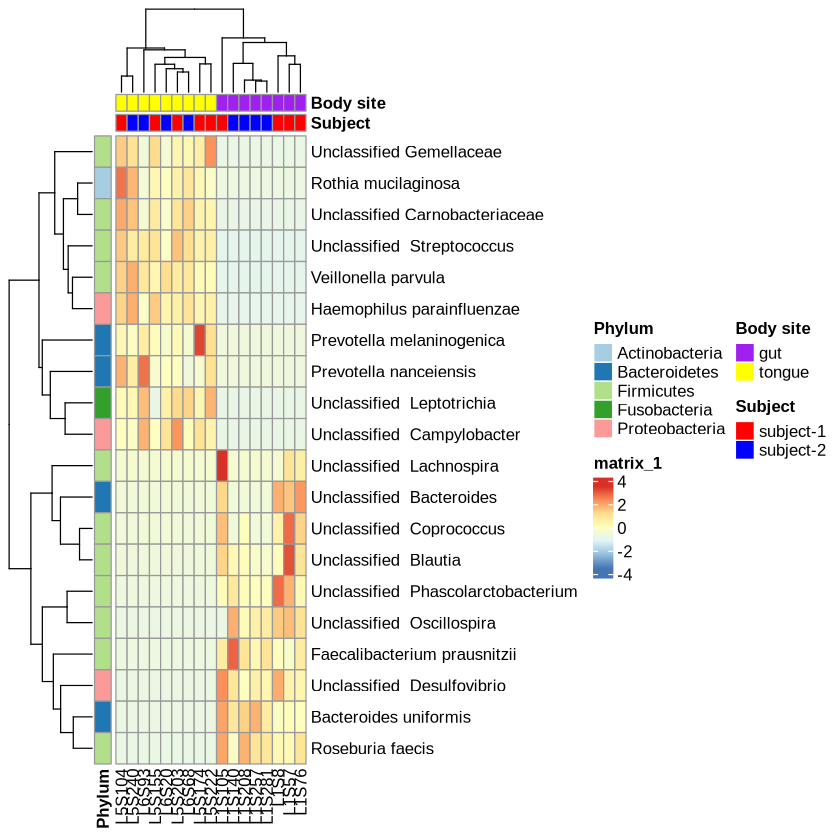

In [26]:
matrix <- as.matrix(data.frame(otu_table(ps.taxa.rel.sig)))
rownames(matrix) <- as.character(tax_table(ps.taxa.rel.sig)[, "Species"])
metadata_sub <- data.frame(sample_data(ps.taxa.rel.sig))
# Define the annotation color for columns and rows
annotation_col = data.frame(
    Subject = as.factor(metadata_sub$subject), 
    `Body site` = as.factor(metadata_sub$body.site), 
    check.names = FALSE
)
rownames(annotation_col) = rownames(metadata_sub)

annotation_row = data.frame(
    Phylum = as.factor(tax_table(ps.taxa.rel.sig)[, "Phylum"])
)
rownames(annotation_row) = rownames(matrix)

# ann_color should be named vectors
phylum_col = RColorBrewer::brewer.pal(length(levels(annotation_row$Phylum)), "Paired")
names(phylum_col) = levels(annotation_row$Phylum)
ann_colors = list(
    Subject = c(`subject-1` = "red", `subject-2` = "blue"),
    `Body site` = c(gut = "purple", tongue = "yellow"),
    Phylum = phylum_col
)

ComplexHeatmap::pheatmap(matrix, scale= "row", 
                         annotation_col = annotation_col, 
                         annotation_row = annotation_row, 
                         annotation_colors = ann_colors)